## Let's start our presentation with a question and answer from the Natural Resources Defense Council:

https://www.nrdc.org/stories/global-warming-101#causes

### Q: What causes global warming?

### A: Global warming occurs when carbon dioxide (CO2) and other air pollutants and greenhouse gases collect in the atmosphere and absorb sunlight and solar radiation that have bounced off the earth’s surface. Normally, this radiation would escape into space—but these pollutants, which can last for years to centuries in the atmosphere, trap the heat and cause the planet to get hotter. That's what's known as the greenhouse effect.


### The Data we have chosen are sourced from the US Government's Earth System Research Laboratory, Global Monitoring Division. The Mauna Loa series (which has the longest continuous series since 1958) is the time series data we have selected for this presentation. This large amount of accurate data will help us use the latest methods in time series analysis to forecast the future. The purpose is to show that statistical forecasts that leverage good data collection and scientific practices can be very precise.

## To have an understanding of causation, let's ask the National Oceanic and Atmospheric Association (NOAA):
### Q: Why are carbon dioxide (CO2) concentrations increasing in the Manua Loa region?
### A: “There is abundant and conclusive evidence that the acceleration is caused by increased emissions”

https://research.noaa.gov/article/ArtMID/587/ArticleID/2636/Rise-of-carbon-dioxide-unabated#:~:text=%E2%80%9CThere%20is%20abundant%20and%20conclusive,of%20Mauna%20Loa%20in%201958.

In [2]:
# import libraries and utilities

import pandas as pd
import numpy as np
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [3]:
# create a pandas dataframe from csv file:

df = pd.read_csv('Data/co2_mm_mlo.csv')

# check first five entries

df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [9]:
# We don't have an actual time series that we can manipulate
# let's format the data as a time series
df['Date'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day':1})

# set the time series as our index 
df = df.set_index('Date')

# set the frequency as monthly frequency (we can see that this is monthly data)

df.index.freq = 'MS'

df.head()

,year,month,decimal_date,average,interpolated
Date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


## When we are told to beware of the future, and these warnings are based on data, what does this data look like?

### Let's see what the data looks like!

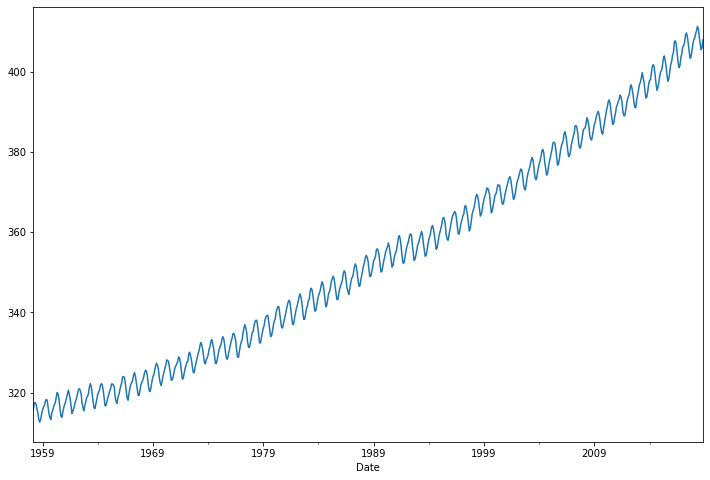

In [11]:
# We can see that there are months missing on the "average"
# column, but the same values plus the missing values are
# available in the interpolated column, we will plot the
# data from here

df['interpolated'].plot(figsize=(12,8));


## Are you serious? We have pretty much the same slope since 1958. We haven't slowed this thing down at all!

In [29]:
# check last date available

df.iloc[-1]

year            2018.000
month             11.000
decimal_date    2018.875
average          408.020
interpolated     408.020
Name: 2018-11-01 00:00:00, dtype: float64

## Is it warranted to beware of the future?

### CO2 levels clearly appear to be trending upward up to the last date available 11/01/2018 (November). Let's confirm this by analyzing the time series components including the trend and seasonality

In [30]:
# use statsmodels seasonal decompose to break the time series down into 
# its components using a period of 12 (monthly) and an additive model
# since there aren't any visible fluctuations in variance

ss_decomposition = seasonal_decompose(x=df['interpolated'], model='additive', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

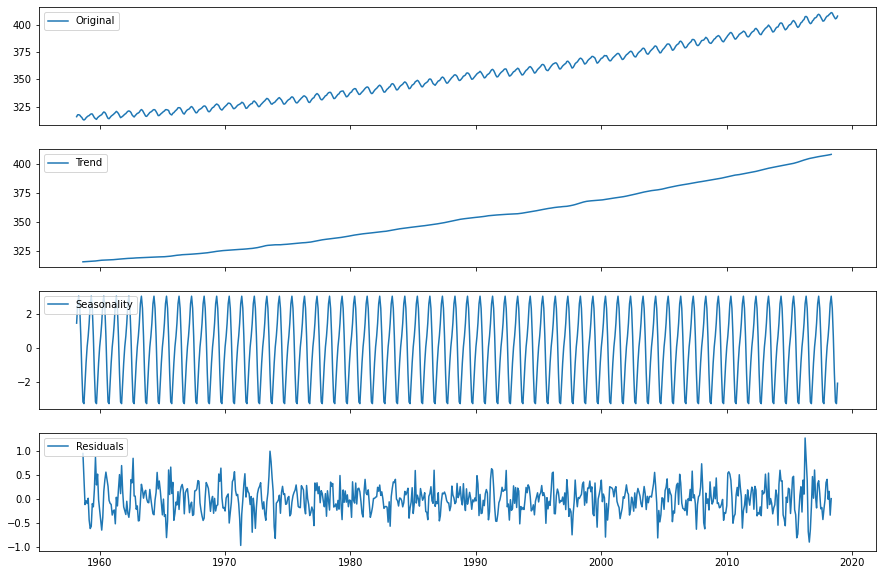

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df['interpolated'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

## Is global warming a real thing?


### It is my goal to show, and it is particularly important today to show, clearly, that green house effect and other science based forecasts are mathematically and scientifically determined. Yes, with a clear upward trend like this, and so many years of carefully collected data, we can PREDICT THE FUTURE quite accurately.

### The data shows a clear upward trend component and a strong seasonality component. In order to make accurate forecasts our modeling choice will have to be able to take into consideration both components. Also this data is not stationary, if you look at the original plot before decomposition, you can clearly see the trend changes the series at each point in time and also the seasonality component causes cycles that are also different at each point in time, meaning it could not be considered random or resemble white noise, and in order to analyze it as a time series we would need to difference the data, meaning we have to compute the differences between consecutive observations, and so, our modeling choice has to take into account this differencing.

### We will need to use a SARIMA model, Seasonal AutoRegressive Integrated Moving Average, which per its name accounts for seasonality, autoregressive behavior (meaning each time step has some dependence on the previous one) and an integrated component (accounting for the differencing that was necessary to remove the combined effects of components), the moving average component would tell us that each time step depends on previous errors

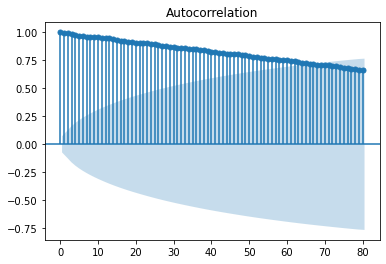

In [36]:
# Checking the order

# We will make plots to review the autocorrelation and partial autocorrelation and 
# make initial guesses on the order of AR, MA, and I components


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['interpolated'], lags=80);

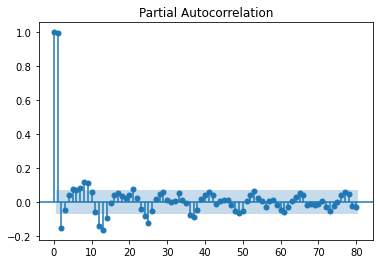

In [37]:
# note that all lags depend on the previous lag in the previous plot,
# here we can see all the higher-order autocorrelations are effectively 
# explained by the lag-1 autocorrelation.

plot_pacf(df['interpolated'], lags=80);

In [38]:
# Based on the plots, we need differencing, at least 1
# for the integrated component (at least one difference to
# make the data stationary) and 1 for the AR term since it 
# seems to have an AR signature being positive at lag 1 on the PACF
# plot and then dropping off

# MA(p) = 0
# I(d) = 1
# AR(q) = 1

# we would expect ARIMA (p=0, d=1, q=1) 

In [39]:
# let's confirm our suspicions on the Integrated component of 1
# let's difference the series once and check if it becomes
# stationary (white noise, random, etc)
from statsmodels.tsa.statespace.tools import diff

df['Diff_1'] = diff(df['interpolated'], k_diff=1)

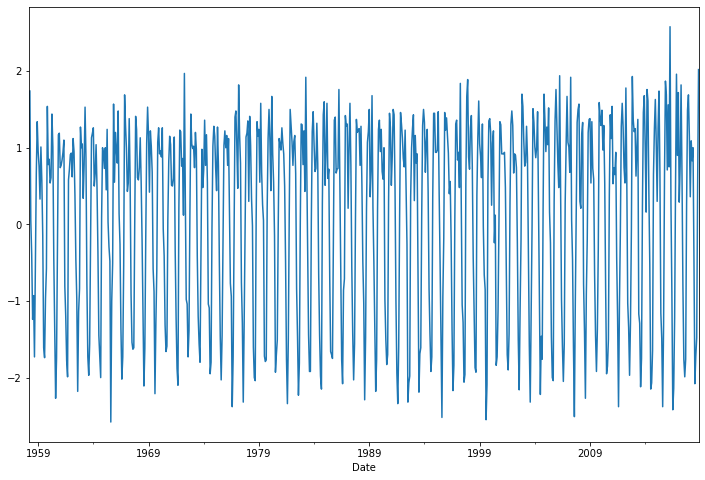

In [40]:
# check if the time series has no trend and appears random
# like 'white noise' after differencing

df['Diff_1'].plot(figsize=(12,8));

In [41]:
# looks right,
# we can run the adfuller test to confirm the data is stationarity
# after this first differencing

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [42]:
adf_test(df['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.200976
p-value                   0.000009
# lags used              20.000000
# observations          707.000000
critical value (1%)      -3.439633
critical value (5%)      -2.865637
critical value (10%)     -2.568952
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [43]:
# Now that we have a fairly good idea of the order that we should expect let's do 
# a grid search for the best model and to obtain the trend and seasonal components

auto_arima(df['interpolated'], seasonal=True, m=12, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -209.730
Date:                            Fri, 15 Jan 2021   AIC                            429.460
Time:                                    15:40:50   BIC                            452.411
Sample:                                         0   HQIC                           438.316
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.578e-05      0.000      0.278      0.781      -0.000       0.000
ma.L1         -0.3681      0.033    -11.086      0.000      -0.433      -0.303
ar.S.L12       0.9995      0.000   2454.535      0.000       0.999       1.000
ma.S.L12      -0.8638      0.023    -38.365      0.000      -0.908      -0.820
sigma2         0.0987      0.005     19.719      0.000       0.089       0.109
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.47
Prob(Q):                              0.70   Prob(JB):                         0.18
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# The ARIMA components look correct
# let's test by fitting the model 
# with the grid search hyperparameters

# create train and test sets
train = df.iloc[:717]
test = df.iloc[717:]

model = SARIMAX(train['interpolated'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.149
Date:                            Fri, 15 Jan 2021   AIC                            418.298
Time:                                    16:15:33   BIC                            436.593
Sample:                                03-01-1958   HQIC                           425.362
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3711      0.030    -12.239      0.000      -0.430      -0.312
ar.S.L12       0.9997      0.000   3098.058      0.000       0.999       1.000
ma.S.L12      -0.8643      0.023    -37.656      0.000      -0.909      -0.819
sigma2         0.0960      0.005     20.459      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.70   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

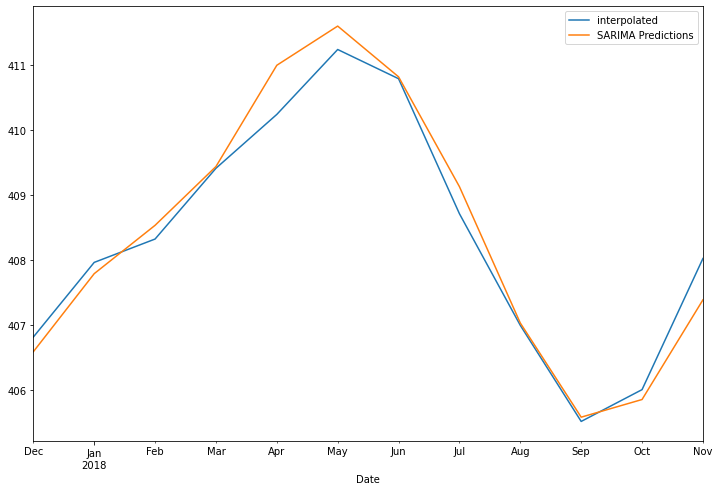

In [46]:
# get a nice close view of the fit

test['interpolated'].plot(legend=True, figsize=(12,8));
predictions.plot(legend=True);

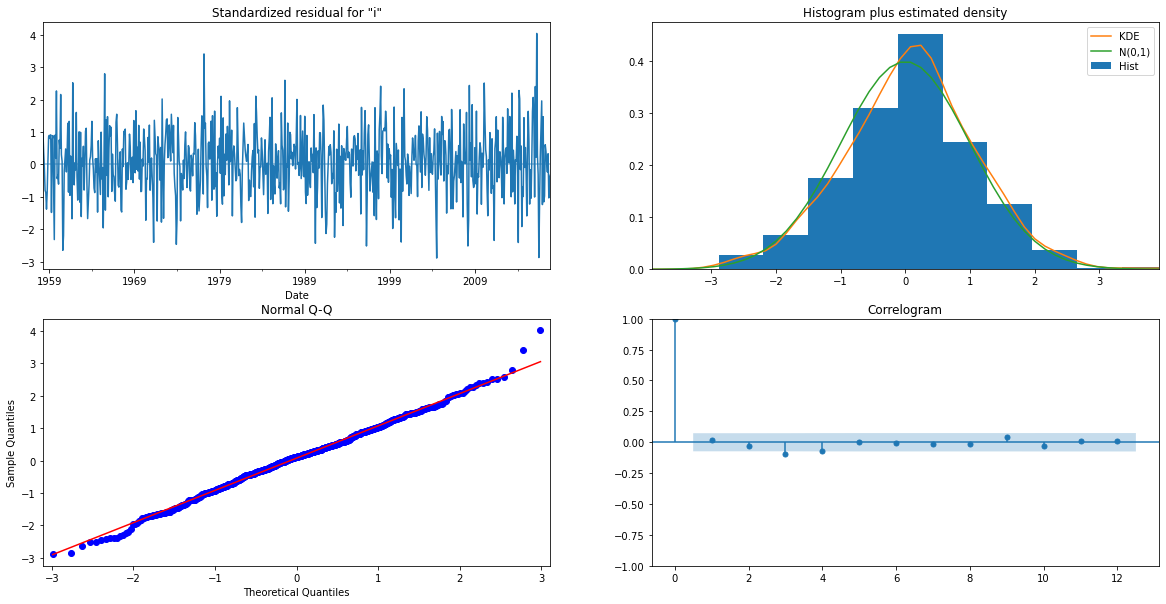

In [47]:
# plot residual diagnostics

# We can see residuals are well behaved
# Error resembles a normal distribution 
# with no correlations, etc.

results.plot_diagnostics(lags=12,figsize = (20,10),);

## Is the truth, the truth?

### There has been a lot of underminding of science and facts lately, especially related to items like climate change. I think it is important for people to see how facts are generated. One way to do it is by reading this notebook. In addition, feel free to explore any of the links that I used as references to see how the original data was generated. Never stop questioning were data come from and how predictions are generated. It is really not difficult to find out the details and judge for yourself.

### Now we will fit the model again but this time on the entire data set and then we will predict into the future, recall that this data set ended on 11/01/2018, and that it is monthly data. This notebook is being generated on Friday 1/15/2021 and so we will forecast into january 2021 with our fitted model and compare the prediction to the actual data, which is consitently being generated by the Earth System Research laboratory

In [48]:
# Create model by fitting entire data set

model = SARIMAX(df['interpolated'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()

In [49]:
# forecast adding 35 periods + 1

fcast = results.predict(len(df), len(df)+35, typ='levels').rename('SARIMA FORECAST')

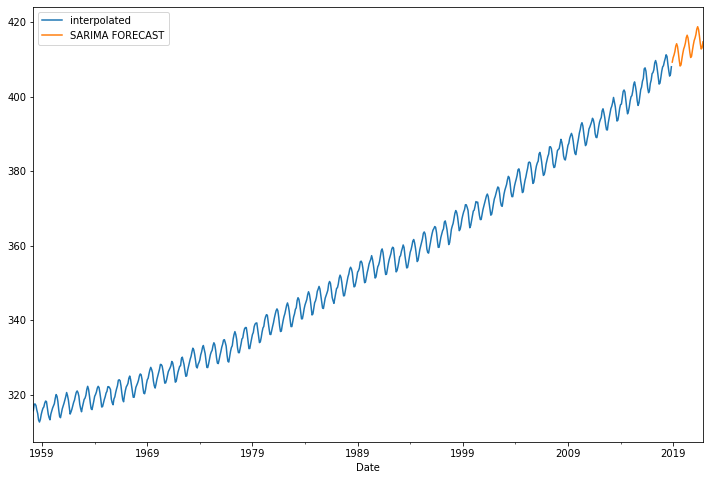

In [50]:
df['interpolated'].plot(legend=True, figsize=(12,8));
fcast.plot(legend=True);

In [51]:
# Check our prediction for this month
fcast['2021-01-01']

415.03534263466156

# How close is our prediction to the actual daily average (as of January 10th on website) ?

https://www.esrl.noaa.gov/gmd/ccgg/trends/monthly.html

# January 10 2021 daily avg = 414.84

In [52]:
closeness = 414.84/fcast['2021-01-01']*100
closeness

99.9529334939474

In [53]:
100 - closeness

0.04706650605260165

## Our prediction is a 99.95% match of the daily average on this day or another way of looking at it, it is off by 0.05% from the daily average on this day).

## This is a considerably close prediction. If you review the website it doesn't look like the monthly average is going to be that much off from this. Although, if you wish you can recalculate based on the monthly average after the data is collected, but based on a prediction more than a couple of years ahead of the data, I would say: Beware of the future!

## CO2 levels continue to increase aggressively and these increased levels, if you check the references in this notebook are caused (not correlated) by increased emissions. I think we need to really pay attention to evidence based FACTS and try our best to avoid being biased by poorly supported opinions, plain ignorance or politics. The future of our world depends on educated judgement. Educated judgement simply depends on carefully reviewing the evidence that supports the notions that make up our beliefs.